## Import the modules

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
import os
from imblearn.over_sampling import SMOTE
import imblearn
from sklearn.neighbors import KNeighborsClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import cross_val_score



In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
# Print the shape of the DataFrame (number of rows and columns)
print(df.shape)

print("\n \n")

# Check for missing values in the DataFrame
print(df.isna().sum())

print("\n \n")
# Found 201 NULL values in bmi column
# Get summary statistics for the numerical columns in the DataFrame


(5110, 12)

 

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

 



In [4]:
print(df.describe())

print("\n \n")
# Get information about the DataFrame, including column data types and number of non-null values
print(df.info())

print("\n \n")

# Print the data types of each column in the DataFrame
print(df.dtypes)

                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0

In [5]:
# We must check that there are no unexpected unique values in each column
for col in df.columns:
  if df[col].dtype != 'float64':
    print(f"{col} has unique values:{df[col].unique()}")

id has unique values:[ 9046 51676 31112 ... 19723 37544 44679]
gender has unique values:['Male' 'Female' 'Other']
hypertension has unique values:[0 1]
heart_disease has unique values:[1 0]
ever_married has unique values:['Yes' 'No']
work_type has unique values:['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type has unique values:['Urban' 'Rural']
smoking_status has unique values:['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke has unique values:[1 0]


#### Fill the na value with mean of BMI 

In [6]:
# We will fill the null values of bmi column with the mean of this column
df['bmi'].fillna(value=df['bmi'].mean(),inplace=True)
print("after filling null values:",df.isna().sum())

after filling null values: id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


#### Drop the ID column as it is not relevant for modeling

In [7]:
## Drop the ID column as it is not relevant for modeling
df.drop('id', axis=1, inplace=True)

In [8]:
# Convert the stroke column to integers (0 for no stroke, 1 for stroke)
df['stroke'] = df['stroke'].astype(int)

## Pre Processing + EDA

In [9]:
#### Target Feature - Stroke

In [10]:
print("Value count in the stroke : \n",df['stroke'].value_counts())


Value count in the stroke : 
 0    4861
1     249
Name: stroke, dtype: int64


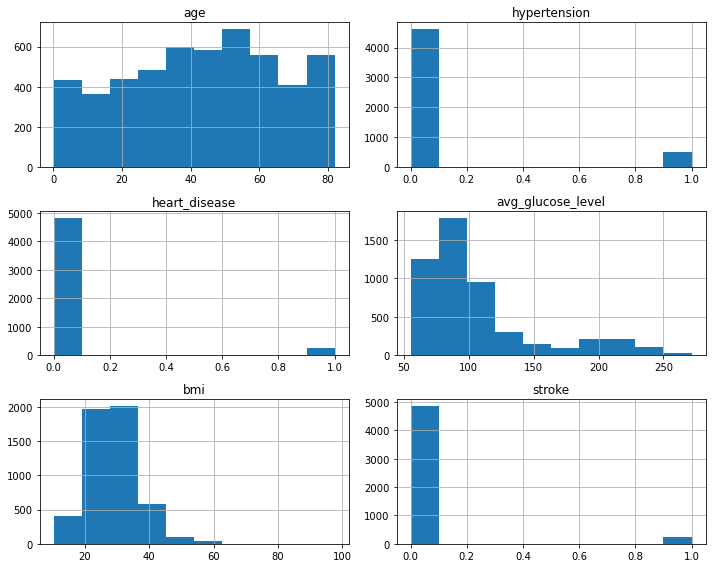

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


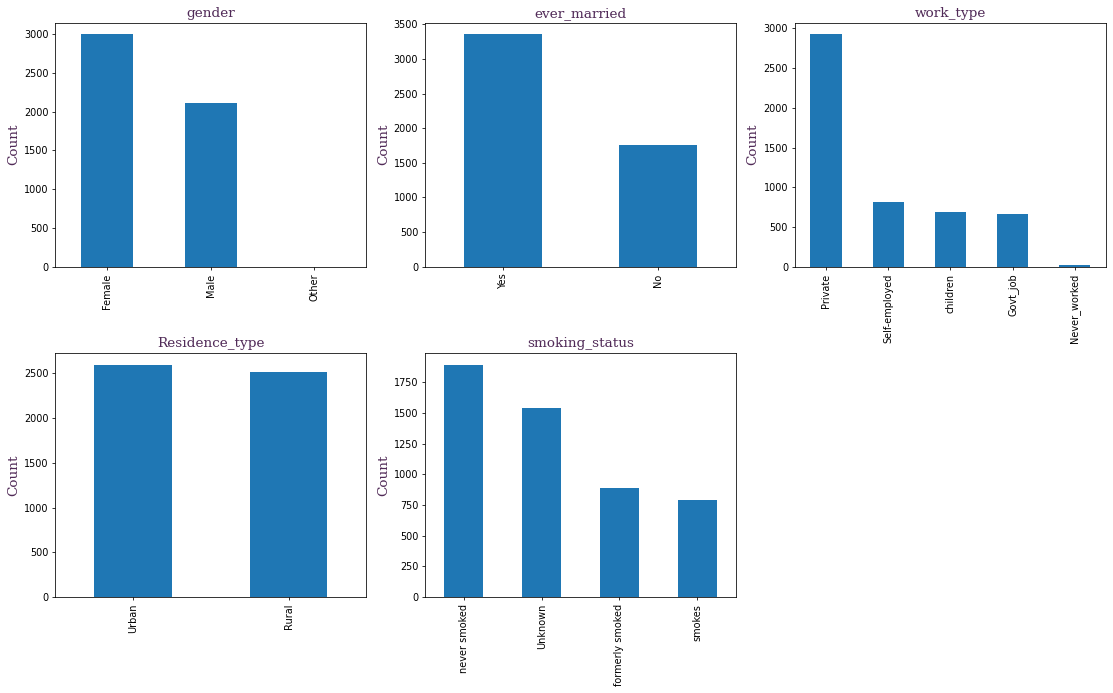

In [11]:
fig = df.hist(figsize=(10,8))
plt.tight_layout()
plt.show()
categorical_cols = df.select_dtypes(include=['object']).columns
print(categorical_cols)
ncols = 3
nrows = np.ceil(len(categorical_cols) / ncols).astype(int)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), dpi=70)
axs = axs.flatten()
for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axs[i])
    axs[i].set_title(col, fontdict={'fontname': 'Serif', 'fontsize': 14, 'color': '#512b58'})
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Count", fontdict={'fontname': 'Serif', 'fontsize': 14, 'color': '#512b58'})
for i in range(len(categorical_cols), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()

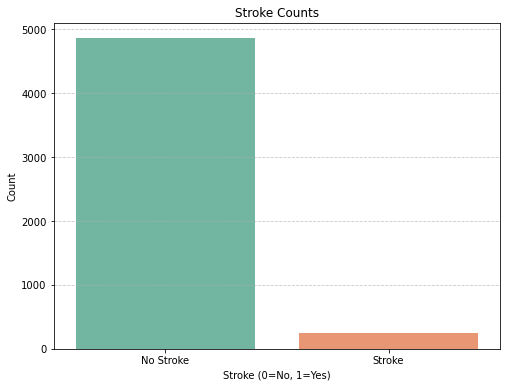

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x='stroke', data=df, palette='Set2', ax=ax)
ax.set_title('Stroke Counts')
ax.set_xlabel('Stroke (0=No, 1=Yes)')
ax.set_ylabel('Count')
ax.set_xticklabels(['No Stroke', 'Stroke'])
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Value of count of smoking status-
 never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


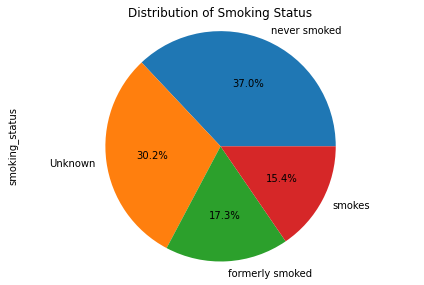

In [13]:
# Smoking status Analysis
print("Value of count of smoking status-\n",df['smoking_status'].value_counts())
# Plot a bar chart of stroke cases by smoking status -pie
df['smoking_status'].value_counts().plot(kind="pie", autopct='%1.1f%%')
plt.title('Distribution of Smoking Status')
plt.axis('equal')
plt.tight_layout()
plt.show()

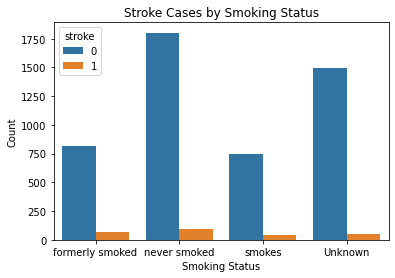

In [14]:
# Bar chart
sns.countplot(x='smoking_status', hue='stroke', data=df)
plt.title('Stroke Cases by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.show()

Value of count of residence-
 Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


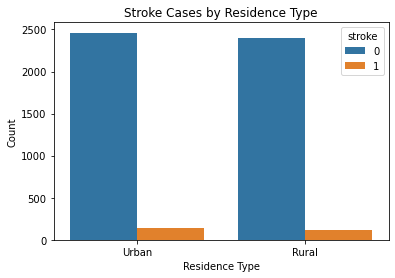

In [15]:
# #Residence Type:
print("Value of count of residence-\n",df['Residence_type'].value_counts())
# Plot a bar chart of stroke cases by residence type
sns.countplot(x='Residence_type', hue='stroke', data=df)
plt.title('Stroke Cases by Residence Type')
plt.xlabel('Residence Type')
plt.ylabel('Count')
plt.show()


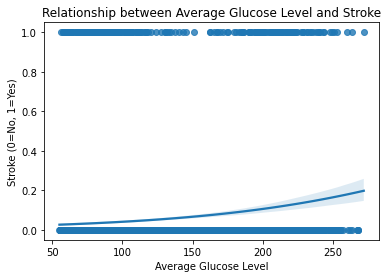

In [16]:
# Average Glucose Level:
sns.regplot(x='avg_glucose_level', y='stroke', data=df, logistic=True)
plt.title('Relationship between Average Glucose Level and Stroke')
plt.xlabel('Average Glucose Level')
plt.ylabel('Stroke (0=No, 1=Yes)')
plt.show()

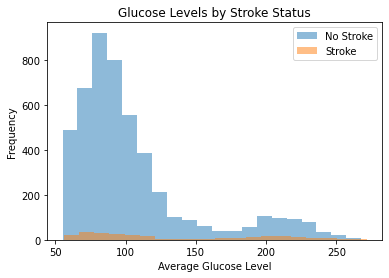

In [17]:
# # Plot histograms of glucose levels for those with and without stroke
plt.hist(df[df['stroke'] == 0]['avg_glucose_level'], alpha=0.5, label='No Stroke', bins=20)
plt.hist(df[df['stroke'] == 1]['avg_glucose_level'], alpha=0.5, label='Stroke', bins=20)
plt.title('Glucose Levels by Stroke Status')
plt.xlabel('Average Glucose Level')
plt.ylabel('Frequency')
plt.legend()
plt.show()

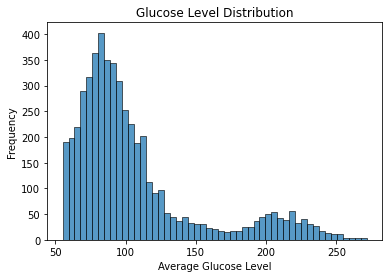

In [18]:
# Plot histogram of glucose levels for entire dataset
sns.histplot(data=df['avg_glucose_level'])
plt.title('Glucose Level Distribution')
plt.xlabel('Average Glucose Level')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# BMI
sns.regplot(x='bmi', y='stroke', data=df, logistic=True)
plt.title('Relationship between BMI and Stroke')
plt.xlabel('BMI')
plt.ylabel('Stroke (0=No, 1=Yes)')
plt.show()

In [ ]:
# Plot histograms of BMI for those with and without stroke
plt.hist(df[df['stroke'] == 0]['bmi'], alpha=0.5, label='No Stroke', bins=20)
plt.hist(df[df['stroke'] == 1]['bmi'], alpha=0.5, label='Stroke', bins=20)
plt.title('BMI by Stroke Status')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Plot  BMI for entire dataset
sns.histplot(data=df['bmi'])
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#%%
# # Checking Outliers Using Box -Plot - for BMI, AVG Glucose Level
nums = list(df.select_dtypes(include=['int64','float64']))
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(0, len(nums)):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[nums[i]],color='green',orient='v')
    plt.tight_layout()

In [ ]:
# Methods for treating outliers in the BMI variable
outlier = ['avg_glucose_level', 'bmi']
Q1 = df[outlier].quantile(0.25)
Q3 = df[outlier].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[outlier]<(Q1-1.5*IQR))|(df[outlier]>(Q3+1.5*IQR))).any(axis=1)]
df.reset_index(drop=True)
plt.figure(figsize=(20, 10))
for i in range(0, len(nums)):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[nums[i]],color='green',orient='v')
    plt.tight_layout()
plt.show()

In [ ]:
# Plotting age histogram
plt.hist(df['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

print("\n")

# Plotting ever married pie chart
fig = plt.figure(facecolor='white')
ever_married_counts = df['ever_married'].value_counts()
plt.pie(ever_married_counts.values, labels=ever_married_counts.index, autopct='%1.1f%%')
plt.title('Ever Married Distribution')
plt.show()

In [ ]:
# Plotting age histogram for strokes
plt.hist(df[df['stroke'] == 1]['age'],bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution for Stroke Cases')
plt.show()

In [ ]:
# Plotting age histogram for strokes
plt.hist(df[df['stroke'] == 1]['age'],bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution for Stroke Cases')
plt.show()

In [ ]:
# Plotting heart disease bar chart
heart_disease_counts = df['heart_disease'].value_counts()
plt.bar(heart_disease_counts.index, heart_disease_counts.values)
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease'])
plt.ylabel('Count')
plt.title('Heart Disease Distribution')
plt.show()

In [ ]:
# Plotting heart disease bar chart for strokes
heart_disease_counts = df[df['stroke'] == 1]['heart_disease'].value_counts()
plt.bar(heart_disease_counts.index, heart_disease_counts.values)
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease'])
plt.ylabel('Count')
plt.title('Heart Disease Distribution for Stroke Cases')
plt.show()

In [ ]:
# Plotting age vs heart disease for strokes
plt.scatter(df[df['stroke'] == 1]['age'], df[df['stroke'] == 1]['heart_disease'],
            label='Stroke', color='red', alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Heart Disease')
plt.title('Age vs Heart Disease for Stroke Cases')
plt.legend()
plt.show()

In [ ]:
# Plotting ever married pie chart for strokes
fig = plt.figure(facecolor='white')
ever_married_counts = df[df['stroke'] == 1]['ever_married'].value_counts()
plt.pie(ever_married_counts.values, labels=ever_married_counts.index, autopct='%1.1f%%')
plt.title('Ever Married Distribution for Stroke Cases')
plt.show()

In [ ]:
# Plotting age vs ever married for strokes
plt.scatter(df[df['stroke'] == 1]['age'], df[df['stroke'] == 1]['ever_married'],
            label='Stroke', color='red', alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Ever Married')
plt.title('Age vs Ever Married for Stroke Cases')
plt.legend()
plt.show()

In [ ]:
# Plotting ever married vs heart disease for strokes
ever_married_counts = df[df['stroke'] == 1]['ever_married'].value_counts()
heart_disease_counts = df[df['stroke'] == 1]['heart_disease'].value_counts()
plt.bar(['Not Ever Married, No Heart Disease', 'Not Ever Married, Heart Disease',
         'Ever Married, No Heart Disease', 'Ever Married, Heart Disease'],
        [df[(df['ever_married'] == 'No') & (df['heart_disease'] == 0) & (df['stroke'] == 1)].shape[0],
         df[(df['ever_married'] == 'No') & (df['heart_disease'] == 1) & (df['stroke'] == 1)].shape[0],
         df[(df['ever_married'] == 'Yes') & (df['heart_disease'] == 0) & (df['stroke'] == 1)].shape[0],
         df[(df['ever_married'] == 'Yes') & (df['heart_disease'] == 1) & (df['stroke'] == 1)].shape[0]],
        color=['green', 'red', 'purple', 'blue'], alpha=0.5)
plt.ylabel('Count')
plt.title('Ever Married vs Heart Disease Distribution for Stroke Cases')
plt.xticks(rotation=45)
plt.show()

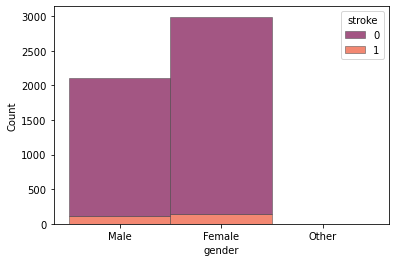

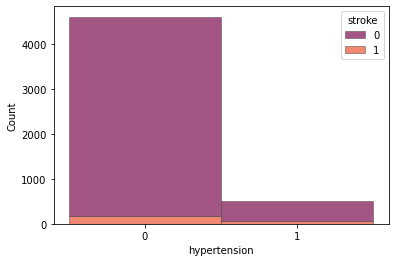

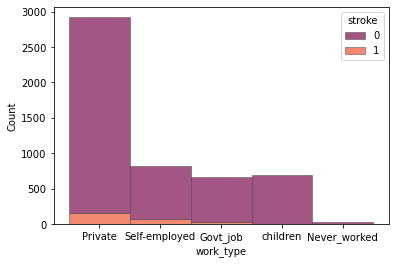

In [25]:
#Stacked Histogram of Gender and Stroke
sns.histplot(data=df, x='gender',hue='stroke',
    multiple="stack",
    palette="rocket",
    edgecolor=".3",
    linewidth=.5)
plt.show()
#Stacked Histogram of hypertension and Stroke
sns.histplot(data=df, x='hypertension',hue='stroke',
    bins=[-0.5, 0.5, 1.5],
    discrete=True,
    multiple="stack",
    palette="rocket",
    edgecolor=".3",
    linewidth=.5)
plt.xticks([0, 1])
plt.show()
#Stacked Histogram of Work type and Stroke
sns.histplot(data=df, x='work_type',hue='stroke',
    multiple="stack",
    palette="rocket",
    edgecolor=".3",
    linewidth=.5)
plt.show()

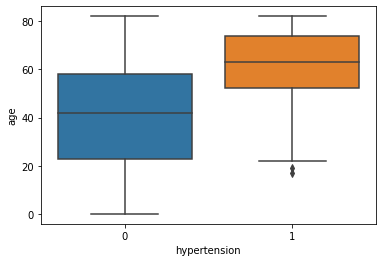

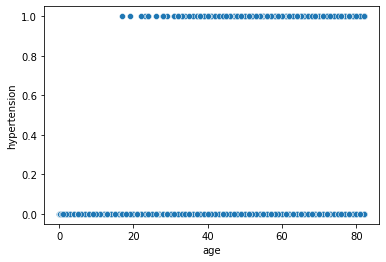

In [26]:
#Box Plot of hypertension vs age
sns.boxplot(x='hypertension', y='age', data=df)
plt.show()
#Scatter plot of Hypertention vs age
sns.scatterplot(x='age', y='hypertension', data=df)
plt.show()

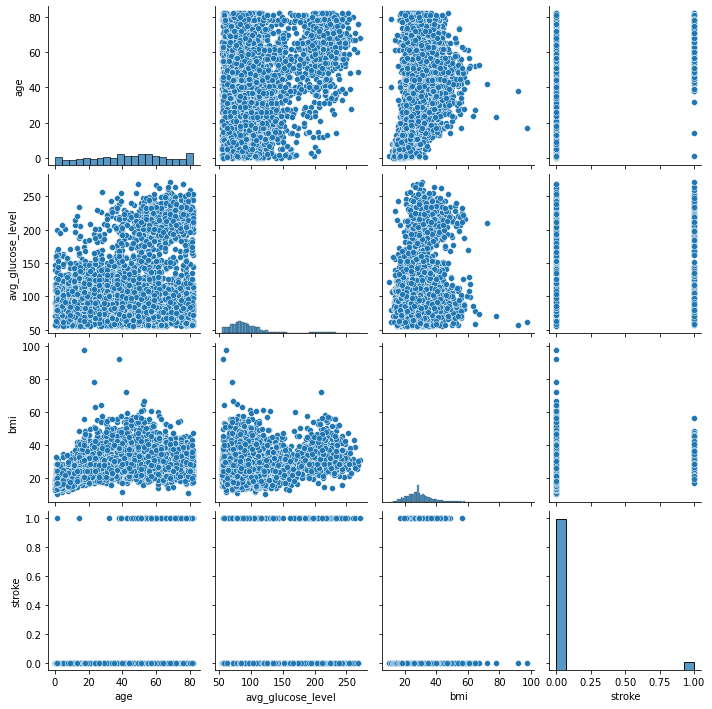

In [27]:
#Pair plot for age, avg glucose level, bmi and stroke
sns.pairplot(df[['age', 'avg_glucose_level', 'bmi', 'stroke']])
plt.show()

# Label Encoding

In [39]:
# Label Encoding
categorical_col=['gender','ever_married','work_type','Residence_type','smoking_status']
le = LabelEncoder()
for col in categorical_col:
  df[col] = le.fit_transform(df[col])

KeyError: 'gender'

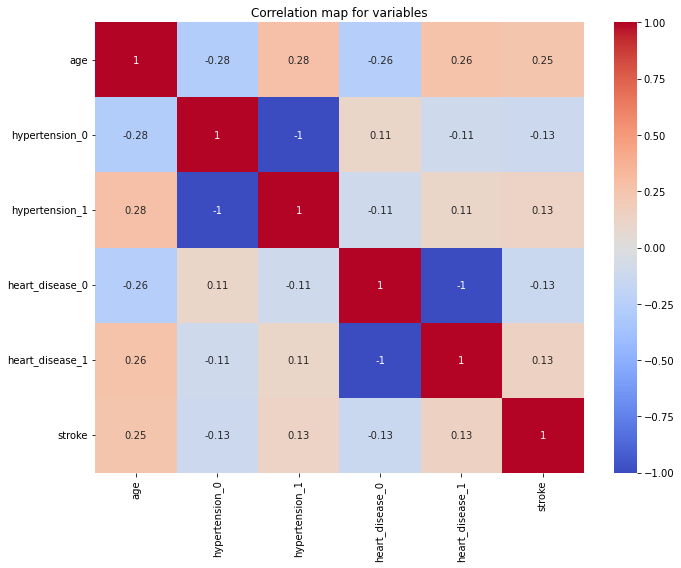

                      age  hypertension_0  hypertension_1  heart_disease_0  \
age              1.000000       -0.276398        0.276398        -0.263796   
hypertension_0  -0.276398        1.000000       -1.000000         0.108306   
hypertension_1   0.276398       -1.000000        1.000000        -0.108306   
heart_disease_0 -0.263796        0.108306       -0.108306         1.000000   
heart_disease_1  0.263796       -0.108306        0.108306        -1.000000   
stroke           0.245257       -0.127904        0.127904        -0.134914   

                 heart_disease_1    stroke  
age                     0.263796  0.245257  
hypertension_0         -0.108306 -0.127904  
hypertension_1          0.108306  0.127904  
heart_disease_0        -1.000000 -0.134914  
heart_disease_1         1.000000  0.134914  
stroke                  0.134914  1.000000  


KeyError: "None of [Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',\n       'Residence_type', 'smoking_status'],\n      dtype='object')] are in the [columns]"

In [40]:
# HeatMap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation map for variables')
plt.tight_layout()
plt.show()
correlation = df.corr()
print(correlation)
#%%

# Encode categorical variables
df = pd.get_dummies(df, columns=['gender','hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type','smoking_status'])

In [41]:
# Feature Engineering:
df = df[['age', 'hypertension_0', 'hypertension_1', 'heart_disease_0', 'heart_disease_1', 'stroke']]
# df = df[['age', 'hypertension', 'heart_disease', 'stroke']]
X = df.drop(['stroke'], axis=1)

y = df['stroke']

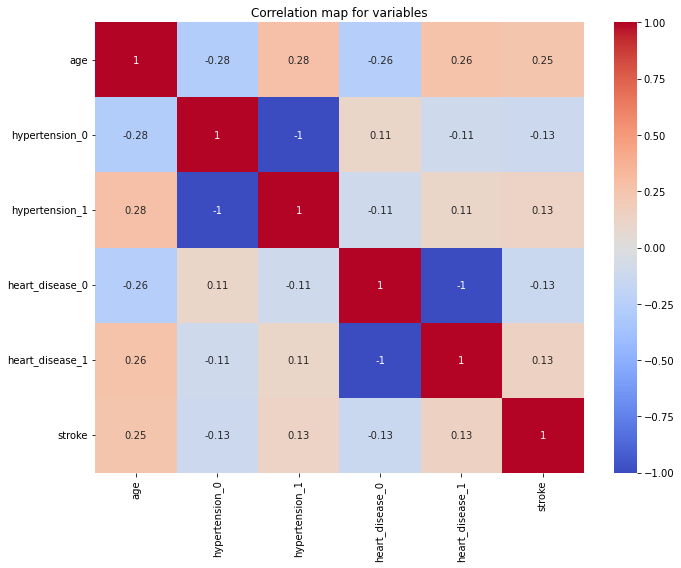

                      age  hypertension_0  hypertension_1  heart_disease_0  \
age              1.000000       -0.276398        0.276398        -0.263796   
hypertension_0  -0.276398        1.000000       -1.000000         0.108306   
hypertension_1   0.276398       -1.000000        1.000000        -0.108306   
heart_disease_0 -0.263796        0.108306       -0.108306         1.000000   
heart_disease_1  0.263796       -0.108306        0.108306        -1.000000   
stroke           0.245257       -0.127904        0.127904        -0.134914   

                 heart_disease_1    stroke  
age                     0.263796  0.245257  
hypertension_0         -0.108306 -0.127904  
hypertension_1          0.108306  0.127904  
heart_disease_0        -1.000000 -0.134914  
heart_disease_1         1.000000  0.134914  
stroke                  0.134914  1.000000  


In [42]:
# HeatMap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation map for variables')
plt.tight_layout()
plt.show()
correlation = df.corr()
print(correlation)

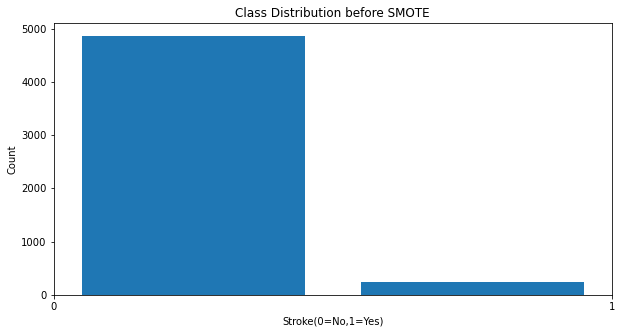

In [43]:
## SPLIT TEST AND TRAIN PART
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.figure(figsize=(10, 5))
plt.title("Class Distribution before SMOTE")
plt.hist(y, bins=2, rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel("Stroke(0=No,1=Yes)")
plt.ylabel("Count")
plt.show()
unique, counts = np.unique(y_train, return_counts=True)

In [44]:
# Print the count of instances in each class before oversampling
print("Class counts before SMOTE oversampling:")
for i in range(len(unique)):
    print("Class", unique[i], ":", counts[i])

Class counts before SMOTE oversampling:
Class 0 : 3901
Class 1 : 187


In [45]:
# Apply SMOTE oversampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

No handles with labels found to put in legend.


Class counts after SMOTE oversampling:
Class 0 : 3901
Class 1 : 3901


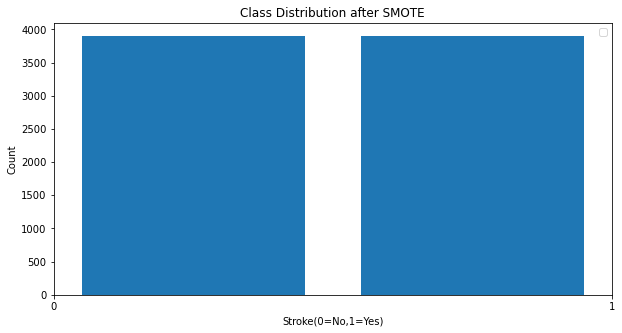

In [46]:
# Count the number of instances in each class after oversampling
unique, counts = np.unique(y_train, return_counts=True)
#%%
# Print the count of instances in each class after oversampling
print("Class counts after SMOTE oversampling:")
for i in range(len(unique)):
    print("Class", unique[i], ":", counts[i])
plt.figure(figsize=(10, 5))
plt.title("Class Distribution after SMOTE")
plt.hist(y_train, bins=2, rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel("Stroke(0=No,1=Yes)")
plt.ylabel("Count")
plt.legend()
plt.show()

In [49]:
# Perform feature scaling 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest

random-forest confusion matrix 
 [[860 100]
 [ 38  24]]
random-forest Classification report 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       960
           1       0.19      0.39      0.26        62

    accuracy                           0.86      1022
   macro avg       0.58      0.64      0.59      1022
weighted avg       0.91      0.86      0.89      1022

Accuracy-Random-forest
: 0.8649706457925636


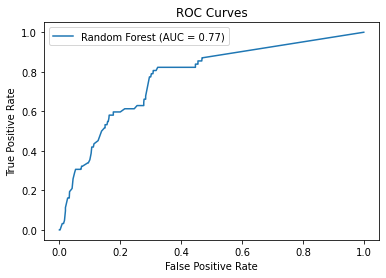

In [50]:
# MACHINE LEARNING ALGORITHMS
# RANDOM FOREST
rfc = RandomForestClassifier(random_state=42)
scores = cross_val_score(rfc, X_train_scaled, y_train, cv=10)
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("random-forest confusion matrix \n",confusion_matrix(y_test, y_pred))
print("random-forest Classification report \n",classification_report(y_test, y_pred))
print("Accuracy-Random-forest\n:", accuracy)
y_pred_proba = rfc.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()

# Gradient Boosting Classifier

In [ ]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)
scores = cross_val_score(gbc, X_train_scaled, y_train, cv=10)
# Fit the model to the training data
gbc.fit(X_train_scaled, y_train)
# Use the model to make predictions on the testing data
y_pred = gbc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy-Gradient Boosting Classifier\n:", accuracy)
print("Gradient Boosting Classifier confusion matrix- \n",confusion_matrix(y_test, y_pred))
print("Gradient Boosting Classifier Classification report \n",classification_report(y_test, y_pred))
y_pred_proba = gbc.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Gradient Boosting Classifier (AUC = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()

# XGBOOST

In [ ]:
# XGBOOST
xgb = XGBClassifier()
scores = cross_val_score(xgb, X_train_scaled, y_train, cv=10)
# Train the classifier on the training data
xgb.fit(X_train_scaled, y_train)
# Make predictions on the testing data
y_pred = xgb.predict(X_test_scaled)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("XGBOOST confusion matrix- \n",confusion_matrix(y_test, y_pred))
print("XGBOOST Classification report  \n",classification_report(y_test, y_pred))
print("Accuracy-XGBOOST\n:", accuracy)
y_pred_proba = xgb.predict_proba(X_test_scaled)[:, 1]
# Calculate the AUC score for the XGBoost classifier
auc = roc_auc_score(y_test, y_pred_proba)
# Calculate the false positive rate and true positive rate for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# Plot the ROC curve
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
plot_confusion_matrix(rfc, X_test_scaled, y_test, cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plot_roc_curve(rfc, X_test_scaled, y_test)
plt.title('Random Forest ROC Curve')
plot_confusion_matrix(gbc, X_test_scaled, y_test, cmap='Blues')
plt.title('Gradient Boosting Classifier Confusion Matrix')
plot_roc_curve(gbc, X_test_scaled, y_test)
plt.title('Gradient Boosting Classifier ROC Curve')
plot_confusion_matrix(xgb, X_test_scaled, y_test, cmap='Blues')
plt.title('XGBOOST Confusion Matrix')
plot_roc_curve(xgb, X_test_scaled, y_test)
plt.title('XGBOOST ROC Curve')

In [ ]:
#Random Forest
rfc = RandomForestClassifier(random_state=42)
rfc_scores = cross_val_score(rfc, X_train_scaled, y_train, cv=10)
print('Random Forest Accuracy:', rfc_scores.mean())
#Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)
gbc_scores = cross_val_score(gbc, X_train_scaled, y_train, cv=10)
print('Gradient Boosting Classifier Accuracy:', gbc_scores.mean())
# Support Vector Machine
xgb = XGBClassifier()
xgb_scores = cross_val_score(xgb, X_train_scaled, y_train, cv=10)
print('XGBoost Accuracy:', xgb_scores.mean())

On the below code we use 
## Initialize a Random Forest Classifier and a Recursive Feature Elimination with Cross Validation selector

Recursive Feature Elimination with Cross Validation (RFECV) is a feature selection method that uses a model to recursively eliminate features from a dataset based on their importance in predicting the target variable. The algorithm works by fitting a model to the full feature set and eliminating the least important feature(s) based on a certain criterion (e.g., p-value, feature importance score). Then, the algorithm repeats this process on the remaining feature set until the desired number of features is reached.

RFECV is an extension of Recursive Feature Elimination (RFE), which eliminates features based on a fixed number of features selected beforehand. RFECV, on the other hand, uses cross-validation to estimate the optimal number of features to select, which improves the robustness of the selection process and reduces overfitting.

In [21]:
#%%
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
np.random.seed(123)
# Initialize a Random Forest Classifier and a Recursive Feature Elimination with Cross Validation selector
estimator = RandomForestClassifier()
selector = RFECV(estimator=estimator, step=1, cv=5, scoring='recall')
# Fit the selector to the scaled training data
selector.fit(X_train_scaled, y_train)
# Select the important features from the training and test data using the selector
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

NameError: name 'X_train_scaled' is not defined

In [ ]:
# Train a new model using the selected features with a Multi-layer Perceptron Classifier
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(2,3,2), activation='relu', solver='adam', alpha=0.00001, learning_rate='adaptive')
mlp.fit(X_train_selected, y_train)
# Make predictions on the test data using the trained model
y_pred = mlp.predict(X_test_selected)
# Evaluate Model with Metrics Below
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Model evaluation
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Precision: {precision_score(y_test, y_pred):.3f}')
print(f'Recall: {recall_score(y_test, y_pred):.3f}')
print(f'F1-score: {f1_score(y_test, y_pred):.3f}')


In [ ]:
#  ROC AUC Metric
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# Calculate the AUC score
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Neural network model

In [47]:
# Neural network model
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)
np.random.seed(2)
# Create parameter space for Grid Serch to run and find Best Params
parameter_space = {
    'hidden_layer_sizes': [(80,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [.5],
    'learning_rate': ['adaptive','constant', 'learning'],
}

In [51]:
# GridSearch to find best parameters
from sklearn.model_selection import GridSearchCV
# Tune Params and fit
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5, scoring='recall')
clf.fit(X_train_scaled, y_train)


C:\Users\saich\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\saich\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\saich\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 747, in fit
    self._validate_params()
  File "C:\Users\saich\anaconda3\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\saich\anacond

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.5],
                         'hidden_layer_sizes': [(80,)],
                         'learning_rate': ['adaptive', 'constant', 'learning'],
                         'solver': ['adam']},
             scoring='recall')

MLP confusion matrix 
 [[715 245]
 [ 12  50]]
MLP Classification report 
               precision    recall  f1-score   support

           0       0.98      0.74      0.85       960
           1       0.17      0.81      0.28        62

    accuracy                           0.75      1022
   macro avg       0.58      0.78      0.56      1022
weighted avg       0.93      0.75      0.81      1022

Accuracy-MLP
: 0.7485322896281801


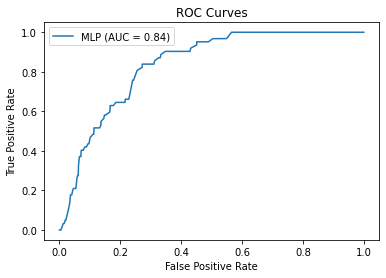

In [62]:
# MACHINE LEARNING ALGORITHMS
# RANDOM FOREST
rfc = MLPClassifier(max_iter=100)
scores = cross_val_score(rfc, X_train_scaled, y_train, cv=10)
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("MLP confusion matrix \n",confusion_matrix(y_test, y_pred))
print("MLP Classification report \n",classification_report(y_test, y_pred))
print("Accuracy-MLP\n:", accuracy)
y_pred_proba = rfc.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='MLP (AUC = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()

In [52]:
# Score Train and Test Data
train_acc = clf.score(X_train_scaled, y_train)
test_acc = clf.score(X_test_scaled, y_test)

print(f'Train accuracy: {train_acc:.3f}')
print(f'Test accuracy: {test_acc:.3f}')
print('Best parameters found:\n', clf.best_params_)

Train accuracy: 0.801
Test accuracy: 0.710
Best parameters found:
 {'activation': 'relu', 'alpha': 0.5, 'hidden_layer_sizes': (80,), 'learning_rate': 'constant', 'solver': 'adam'}


In [53]:
from sklearn.model_selection import cross_val_score

y_pred = clf.predict(X_test_scaled)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Model evaluation
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Precision: {precision_score(y_test, y_pred):.3f}')
print(f'Recall: {recall_score(y_test, y_pred):.3f}')
print(f'F1-score: {f1_score(y_test, y_pred):.3f}')

Accuracy: 0.752
Precision: 0.158
Recall: 0.710
F1-score: 0.258


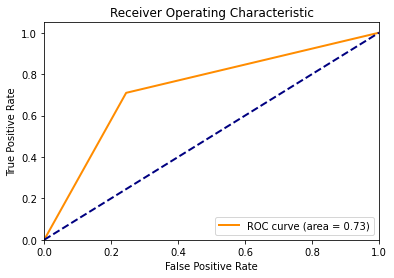

In [54]:
#  ROC AUC Metric
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# Calculate the AUC score
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = Pipeline(steps=[
    ('pca', PCA()),
    ('mlp', MLPClassifier(max_iter=400))
])

# Define the parameter space
parameter_space = {
    'pca__n_components': [1],
    # 'mlp__hidden_layer_sizes': [(2,2,2,2), (3,3,3), (2,3,2)],
    'mlp__hidden_layer_sizes': [(2,3,2)],
    'mlp__activation': ['relu', 'logistic', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    # 'mlp__alpha': [.01, 0.009, 0.05, 0.001],
    'mlp__alpha': [0.01],
    'mlp__learning_rate': ['adaptive', 'learning'],
}

In [56]:
# Create the grid search object
clf = GridSearchCV(pipeline, parameter_space, n_jobs=-1, cv=5, scoring='recall')

# Fit the grid search object to the data
clf.fit(X_train_scaled, y_train)
best_model = clf.best_estimator_
best_param = clf.best_params_
print(best_model)
print(best_param)

C:\Users\saich\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\saich\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\saich\anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\saich\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 747, in fit
    self._validate_params()
  File "C:\U

Pipeline(steps=[('pca', PCA(n_components=1)),
                ('mlp',
                 MLPClassifier(activation='logistic', alpha=0.01,
                               hidden_layer_sizes=(2, 3, 2),
                               learning_rate='adaptive', max_iter=400))])
{'mlp__activation': 'logistic', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (2, 3, 2), 'mlp__learning_rate': 'adaptive', 'mlp__solver': 'adam', 'pca__n_components': 1}


In [57]:
# Make predictions with the best model
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Model evaluation
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Precision: {precision_score(y_test, y_pred):.3f}')
print(f'Recall: {recall_score(y_test, y_pred):.3f}')
print(f'F1-score: {f1_score(y_test, y_pred):.3f}')

              precision    recall  f1-score   support

           0       0.99      0.66      0.79       960
           1       0.15      0.90      0.25        62

    accuracy                           0.68      1022
   macro avg       0.57      0.78      0.52      1022
weighted avg       0.94      0.68      0.76      1022

Accuracy: 0.676
Precision: 0.147
Recall: 0.903
F1-score: 0.253


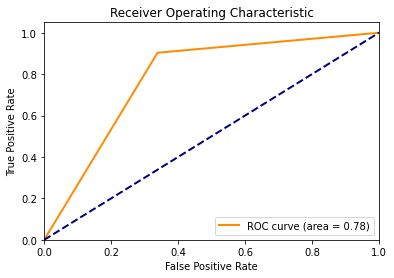

In [58]:
#%%
#  ROC AUC Metric
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# Calculate the AUC score
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [59]:
# Models
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
print('Logistic Regression Accuracy:', accuracy_score(y_test, lr_pred))
print(confusion_matrix(y_test, lr_pred))
print(classification_report(y_test, lr_pred))

print('\n')
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)
print('K-Nearest Neighbors Accuracy:', accuracy_score(y_test, knn_pred))
print(confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

print('\n')
# Support Vector Machine
svm = SVC()
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)
print('Support Vector Machine Accuracy:', accuracy_score(y_test, svm_pred))
print(confusion_matrix(y_test, svm_pred))
print(classification_report(y_test, svm_pred))



Logistic Regression Accuracy: 0.764187866927593
[[740 220]
 [ 21  41]]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       960
           1       0.16      0.66      0.25        62

    accuracy                           0.76      1022
   macro avg       0.56      0.72      0.56      1022
weighted avg       0.92      0.76      0.82      1022



K-Nearest Neighbors Accuracy: 0.9315068493150684
[[946  14]
 [ 56   6]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       960
           1       0.30      0.10      0.15        62

    accuracy                           0.93      1022
   macro avg       0.62      0.54      0.56      1022
weighted avg       0.91      0.93      0.91      1022



Support Vector Machine Accuracy: 0.7514677103718199
[[718 242]
 [ 12  50]]
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       960
           1   

In [60]:
print('\n')

# Create a list of tuples containing model names and instances
models = [('Logistic Regression', lr), ('KNN', knn), ('SVM', svm)]

print('\n')

# Confusion Matrix for Logistic
plot_confusion_matrix(lr, X_test_scaled, y_test, cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')

print('\n')
# ROC Curve for Logistic
plot_roc_curve(lr, X_test_scaled, y_test)
plt.title('Logistic Regression ROC Curve')

print('\n')

# Confusion Matrix for KNN
plot_confusion_matrix(knn, X_test_scaled, y_test, cmap='Blues')
plt.title('KNN Confusion Matrix')

print('\n')
# ROC Curve for KNN
plot_roc_curve(knn, X_test_scaled, y_test)
plt.title('KNN ROC Curve')



NameError: name 'plot_confusion_matrix' is not defined

In [ ]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
# Confusion Matrix for SVM
plot_confusion_matrix(svm, X_test_scaled, y_test, cmap='Blues')
plt.title('SVM Confusion Matrix')
# ROC Curve for SVM
plot_roc_curve(svm, X_test_scaled, y_test)
plt.title('SVM ROC Curve')
# %%
#Cross Validation
# Logistic Regression
lr = LogisticRegression()
lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv=10)
print('Logistic Regression Accuracy:', lr_scores.mean())
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=10)
print('K-Nearest Neighbors Accuracy:', knn_scores.mean())
# Support Vector Machine
svm = SVC()
svm_scores = cross_val_score(svm, X_train_scaled, y_train, cv=10)
print('Support Vector Machine Accuracy:', svm_scores.mean())